In [1]:
import numpy as np
import matplotlib.pyplot as plt
from util.logger import EventTracker
from util.basis_scaled import *
from util.plot_tools import *
from boundary_solvers.gauss_grid_2d import StokesDirichletProblem
from scipy.io import loadmat
import matplotlib.pyplot as plt
from util.interp import PiecewiseInterp2D
from hmm.stokes import *
from itertools import product
from hmm.stokes_deep import DeepMicroSolver, get_net
from boundary_solvers.geometry_torch import interp_periodic
import matplotlib
import torch.nn as nn
import matplotlib as mpl


#matplotlib.rcParams['text.usetex'] = True
#pretty_pyplot_layout()

np.random.seed(0)
net_dir = "/mnt/data0/emastr/article_training_lowline/"
figures_dir = "/home/emastr/deep-micro-slip-model/data/figures/"
run_dir = "/home/emastr/deep-micro-slip-model/data/reference_2/"

#save_dir = "/home/emastr/deep-micro-slip-model/data/hmm_coupling_error/"
save_dir = "/mnt/data0/emastr/hmm_coupling/"
deep_save_dir = "/mnt/data0/emastr/hmm_coupling_deep_and_classic/"

In [2]:
from dataclasses import dataclass
from multiprocessing import Pool
from architecture.session import egeofno_ver1, egeofno_ver2, egeofno_ver3, egeofno_ver4,\
                                 svdfno_ver1, svdfno_ver2, svdfno_ver3, svdfno_ver4,\
                                 fno_ver1, fno_ver2, fno_ver3, fno_ver4
import torch

device = "cpu"
nets = {}
nets.update({f"fno_svd_ver{i+1}": fno for i,fno in enumerate([svdfno_ver1, svdfno_ver2, svdfno_ver3, svdfno_ver4])})
nets.update({f"fno_ver{i+1}": fno for i, fno in enumerate([egeofno_ver1, egeofno_ver2, egeofno_ver3, egeofno_ver4])})
nets.update({f"fno_vanilla_ver{i+1}": fno for i, fno in enumerate([fno_ver1, fno_ver2, fno_ver3, fno_ver4])})


print(list(nets.keys()))
@dataclass
class HyperParams:
    nMic: int
    xDim: int
    yDim: int
    width: float
    height: float
    tol: float
    max_iter: int
    num_pts: int
    xDim_reduce: int = 5
    yDim_reduce: int = 5
    line_pos: float = 0.0
    net_path: str = None
    net_type: str = None
    
    
class Setup():
    def __init__(self, data: StokesData, param: HyperParams):#, net: nn.Module, net_settings: dict):
        """Create a new HMM setup with the given parameters."""
        self.params = param
        self.data = data
        self.data0 = data.copy()
        self.data.dom = [self.data.dom[0], [param.line_pos*param.height+self.data.dom[1][0], self.data.dom[1][1]]]
        
        # Net
        print(f"type {nets[param.net_type]}, loading {param.net_path}")
        net = nets[param.net_type](device=device)
        net_data = torch.load(param.net_path, map_location=torch.device(device))
        net.load_state_dict(net_data["state dict"])
        net_settings =  {"num_pts": param.num_pts, "input_features": net_data["settings"]["input_features"], "output_features": net_data["settings"]["output_features"], "device": device, "dtype": torch.float}
        
        # Naive
        self.macro0 = StokesMacProb(self.data0, lambda x,a: fft_interp(x, a, dom=self.data0.dom[0]))
        self.macro_solver0 = MacroSolver(param.xDim, param.yDim, tol=param.tol)
        
        # Macro
        self.macro = StokesMacProb(self.data, lambda x,a: fft_interp(x, a, dom=self.data.dom[0]))
        self.macro_solver = MacroSolver(param.xDim, param.yDim, tol=param.tol)
        
        # Micro problems
        self.xPos = np.linspace(self.data.dom[0][0], self.data.dom[0][1], param.nMic+1)[1:] - param.width/2 - (self.data.dom[0][1]-self.data.dom[0][0]) / param.nMic
        self.micros = [StokesMicProb(self.data, x, param.width, param.height, param.line_pos, 8, xDim_reduce=param.xDim, yDim_reduce=param.yDim, n_refine=1) for x in self.xPos]
        self.micro_solvers = [MicroSolver(m, tol=param.tol) for m in self.micros]
        self.deep_micro_solvers = [DeepMicroSolver(m, net, net_settings, tol=param.tol) for m in self.micros]
        
        # Convergence checker
        self.conv_checker = ConvergenceChecker(self.macro, self.micros, tol=param.tol)
        
        # HMM problem
        self.hmm_problem = StokesHMMProblem(self.macro, self.micros, self.data, convergence_checker=self.conv_checker)
        self.hmm_solver = IterativeHMMSolver(self.macro_solver, self.micro_solvers)
        self.hmm_deep_solver = IterativeHMMSolver(self.macro_solver, self.deep_micro_solvers)
        self.logger = EventTracker()
        
        
    def solve(self, **kwargs):
        # Naive
        print("Solving naive")
        self.logger.start_event("naive")
        macro_naive = self.macro_solver0.solve(self.macro0)
        self.logger.end_event("naive")
        
        # Deep
        print("Solving deep")
        self.logger.start_event("deep")
        deep_macro_guess = self.hmm_deep_solver.macro_solver.solve(self.hmm_problem.macro)
        (deep_macro_sol, deep_micro_sols) = self.hmm_deep_solver.solve(self.hmm_problem, macro_guess=deep_macro_guess, verbose=True, maxiter=self.params.max_iter, tol=self.params.tol)
        self.logger.end_event("deep")
        
        # Classical
        print("Solving Classical")
        self.logger.start_event("classical")
        macro_guess = self.hmm_solver.macro_solver.solve(self.hmm_problem.macro)
        (macro_sol, micro_sols) = self.hmm_solver.solve(self.hmm_problem, macro_guess=macro_guess, verbose=True, maxiter=self.params.max_iter, tol=self.params.tol)
        self.logger.end_event("classical")
        
        #(deep_macro_sol, deep_micro_sols) = self.hmm_deep_solver.solve(self.hmm_problem, macro_guess=macro_guess, verbose=True, maxiter=self.params.max_iter, tol=self.params.tol)
        
        return macro_naive, macro_sol, micro_sols, deep_macro_sol, deep_micro_sols #deep_micro_sols, deep_macro_sol, macro_guess
    
    
    def save_sol(self, naive_sol, macro_sol, deep_macro_sol, filename):
        data = self.params.__dict__
        data['deep_mic_sol'] = [(m.r, m.t) for m in self.hmm_deep_solver.micro_solvers]
        data['mic_sol'] = [(ms.avg_vec, m.geom.grid.get_grid_and_weights()[0]) for ms, m in zip(self.micro_solvers, self.micros)]
        data['naive_sol_u'] = naive_sol.u.eval_grid()
        data['naive_sol_v'] = naive_sol.v.eval_grid()
        data['sol_u'] = macro_sol.u.eval_grid()
        data['sol_v'] = macro_sol.v.eval_grid()
        data['deep_sol_u'] = deep_macro_sol.u.eval_grid()
        data['deep_sol_v'] = deep_macro_sol.v.eval_grid()
        np.save(filename, data)
        
    @staticmethod
    def load_sol(filename):
        data = np.load(filename, allow_pickle=True).flatten()[0]
        u = data.pop('sol_u')
        v = data.pop('sol_v')
        u_deep = data.pop('deep_sol_u', None)
        v_deep = data.pop('deep_sol_v', None)
        u_naive = data.pop('naive_sol_u', None)
        v_naive = data.pop('naive_sol_v', None)
        m = data.pop('deep_mic_sol', None)
        mt = data.pop('mic_sol', None)
        par = HyperParams(**data)
        return par, u_naive, v_naive, u, v, u_deep, v_deep, m, mt#, u_deep, v_deep

['fno_svd_ver1', 'fno_svd_ver2', 'fno_svd_ver3', 'fno_svd_ver4', 'fno_ver1', 'fno_ver2', 'fno_ver3', 'fno_ver4', 'fno_vanilla_ver1', 'fno_vanilla_ver2', 'fno_vanilla_ver3', 'fno_vanilla_ver4']


In [3]:
seeds = list(range(5))

path_from_type_seed = lambda net_type, seed: f"{net_dir}{net_type}_seed{seed}_40000.Torch"


In [4]:
w_list = [4.5, 5, 7, 8]#[3,5,10]#[2,5,7]
height_list = [0.8, 0.7, 1.0]#[0.8, 0.5, 1.0]
line_pos_list = [0.0, 0.01, 0.05, 0.1, 0.2]#[0.0, 0.01, 0.1]
seeds = [0, 1, 2, 3, 4, 5]
types = ["fno_ver1", "fno_ver3", "fno_vanilla_ver3", "fno_vanilla_ver4"]
data_product = product(types, seeds, w_list, height_list, line_pos_list)
data_product_list = list(data_product)

In [10]:
from multiprocessing import Pool
i_list = [2, 42-16, 42, 42+16]#, 74]
e_list = [0.001, 0.005, 0.01, 0.04]

for i, e in zip(i_list, e_list):
    #i = i_list[0]
    #e = e_list[0]

    num_pts = 256

    data, info = StokesData.load_from_matlab(f"{run_dir}run_{i}.mat")
    data_big_domain = data
    dom = data.dom
    eps = info["eps"]
    n = 7
    #w = 5
    
    def loop_func(args):
        try:
            it, (net_type, net_seed, w, h, lp) = args
            with open("/home/emastr/deep-micro-slip-model/data/logs/log.txt", "a") as f:
                f.write(f"BEGUN ----- {it}, i={i}, e={e}, net_type={net_type}, net_seed={net_seed}, w={w}, h={h}, lp={lp}\n")
            params = HyperParams(nMic=n, xDim=21, yDim=21, width=w*eps, height=w*eps*h, tol=1e-8, max_iter=30, num_pts=num_pts,line_pos=lp, net_path=path_from_type_seed(net_type, net_seed), net_type=net_type)
            setup = Setup(data, params)
            macro_naive, macro_sol, micro_sols, deep_macro_sol, deep_micro_sols = setup.solve()
            setup.save_sol(macro_naive, macro_sol, deep_macro_sol, f"{deep_save_dir}hmm_coupling_{i}_{net_type}_{net_seed}_{w}_{h}_{lp}.npy")
            with open("/home/emastr/deep-micro-slip-model/data/logs/log.txt", "a") as f:
                f.write(f"----- ENDED {it}, i={i}, e={e}, net_type={net_type}, net_seed={net_seed}, w={w}, h={h}, lp={lp}\n")
        except:
            print("ERROR - requested net not found")
        

    
    p = Pool(16)
    p.map(loop_func, list(enumerate(data_product_list))[2700:])
    #for it, (net_type, net_seed, w, h, lp) in enumerate(data_product_list):
    #    print(f"################### ITER {it}, i={i}, e={e}, net_type={net_type}, net_seed={net_seed}, w={w}, h={h}, lp={lp} ###################")
    #    
    #    params = HyperParams(nMic=n, xDim=21, yDim=21, width=w*eps, height=w*eps*h, tol=1e-8, max_iter=30, num_pts=num_pts,line_pos=lp, net_path=path_from_type_seed(net_type, net_seed), net_type=net_type)
    #    setup = Setup(data, params)

        #macro_naive, macro_sol, micro_sols, deep_macro_sol, deep_micro_sols = setup.solve()#deep_micro_sols, deep_macro_sol, macro_guess
        #setup.save_sol(macro_naive, macro_sol, deep_macro_sol, f"{deep_save_dir}hmm_coupling_{i}_{it}.npy")

In [5]:
import os
from scipy.interpolate import interp1d
from pandas import DataFrame
step = [1, 2, 3, 4, 6, 8, 11, 16, 22, 32, 46, 64]#, 128]
M_list = [s * 20 for s in step]
#colors = ["indigo", "tomato", "firebrick", "mediumseagreen"]
colors = ["coral", "seagreen", "steelblue", "indianred"]
markers = ["D", "s", "v", "^"]


#try:
rows = []
    
plt.figure(figsize=(7,5))
i_list = [2, 42-16, 42, 42+16]#, 74]
e_list = [0.001, 0.005, 0.01, 0.04]
for i, e in zip(i_list, e_list):
    coupling_error = []
    micro_error = []
    data, info = StokesData.load_from_matlab(f"{run_dir}run_{i}.mat")
    eps = info["eps"]
    
    error_hmm_deep = []
    error_micro_deep = []
    
    for it in range(len(data_product_list)):
        try:
            (net_type, net_seed, w, h, lp) = data_product_list[it]
            #try:
            #par, u_naive, _, u, _, u_deep, _, deep_micsols, micsols = Setup.load_sol(f"{deep_save_dir}hmm_coupling_{i}_{it}.npy")
            par, u_naive, _, u, _, u_deep, _, deep_micsols, micsols = Setup.load_sol(f"{deep_save_dir}hmm_coupling_{i}_{net_type}_{net_seed}_{w}_{h}_{lp}.npy")
            
            
            dom0 = data.dom
            dom = [dom0[0], [lp*h*eps + dom0[1][0], dom0[1][1]]]
            u_f = ScaleShiftedBasisProduct.fromFunctionInDomain(lambda x,y: u, dom, 21, 21, FourBasis, ChebBasis)
            u_naive_f = ScaleShiftedBasisProduct.fromFunctionInDomain(lambda x,y: u_naive, dom0, 21, 21, FourBasis, ChebBasis)
            u_deep_f = ScaleShiftedBasisProduct.fromFunctionInDomain(lambda x,y: u_deep, dom, 21, 21, FourBasis, ChebBasis)
            
            #u_naive = u_naive_f.reduce_eval(0.01, 1)
            #par, u, _, u_deep, _, deep_micsols, micsols = Setup.load_sol(f"{deep_save_dir}hmm_coupling_{i}_{it}.npy")
            #data, u, _, micsols, micsols_true = Setup.load_sol(f"{deep_save_dir}hmm_coupling_{i}_{it}.npy")
            micro_error=0.
            for n in range(7):
                deep_micsol = deep_micsols[n][0]
                deep_t = deep_micsols[n][1]
                
                micsol = micsols[n][0]
                t = micsols[n][1]
        
                micsol_interp = interp_periodic(t, micsol, deep_t)
                error = np.linalg.norm(micsol_interp - deep_micsol)/np.linalg.norm(micsol_interp)
                micro_error = max(micro_error, error)
            
            
            
                
            #print(f"Error for sim {i} with {m} discretisation points")
            (N, M) = u.shape     
            mask = np.linspace(0, 1, M) < eps*np.log(1/eps)
            u_deep_mask = u_deep_f.reduce_eval(eps, 1).eval_grid().real #u_deep[:, mask]
            u_mask = u_f.reduce_eval(eps, 1).eval_grid().real #u[:, mask]
            u_naive_mask = u_naive_f.reduce_eval(eps, 1).eval_grid().real #u_naive[:, mask]
            macro_error = np.linalg.norm(u_mask - u_deep_mask)/np.linalg.norm(u_mask-u_naive_mask)
            
            #if net_type=="fno_ver1" and lp==0.2:
            error_micro_deep.append(micro_error)
            error_hmm_deep.append(macro_error)#np.linalg.norm(u_mask - u_deep_mask)/np.linalg.norm(u_mask - u_naive_mask))
            
            
            rows.append([it, i, e, net_type, net_seed, w, h, lp, micro_error, macro_error])
            #error_hmm_deep.append(np.linalg.norm(u_mask - u_deep_mask)/np.linalg.norm(u_mask - u_naive_mask))        
            #except:
                #continue

            
            if False: #i == 42 and it == 8:
                plt.figure(2)
                #plt.plot(t, micsols[0])    
                plt.plot(deep_t, micsol_interp, label="true")
                plt.plot(deep_t, deep_micsol, label="deep")
                plt.legend()
                #plt.plot(t, micsol_interp)
                
                plt.figure(3)
                #plt.plot(u_deep[:, 0], label="deep")
                #plt.plot(u[:, 0], '--', label="true")
                axis = 1
                y_eval = eps
                u_deep_f.reduce_eval(y_eval, axis).plot(plt.gca(), dim=100)
                u_f.reduce_eval(y_eval, axis).plot(plt.gca(), dim=100)
                u_naive_f.reduce_eval(y_eval, axis).plot(plt.gca(), dim=100)
                plt.legend()
        except:
            continue
            
        
    #plt.figure(1)
    #print(len(error_hmm_deep), len(error_micro_deep))
    #plt.plot(M_list[:-1], coupling_error, label=f"$epsilon = {eps:.0e}$")
    #plt.scatter(error_micro_deep, error_hmm_deep)
    

    


<Figure size 700x500 with 0 Axes>

/home/emastr/anaconda3/envs/pimlenv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1345: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/home/emastr/anaconda3/envs/pimlenv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1345: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


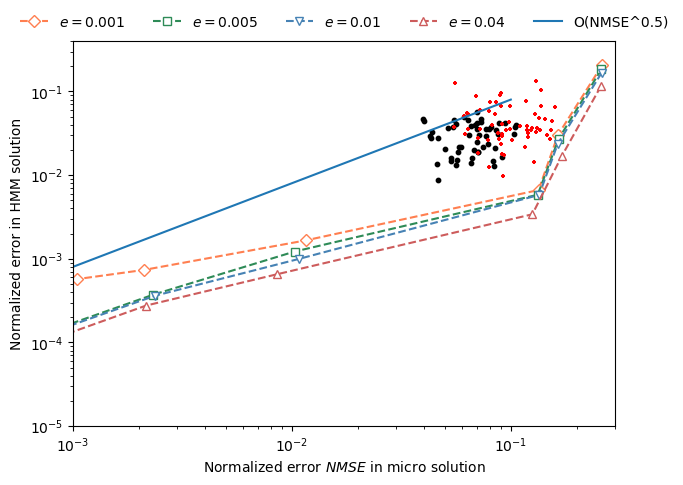

In [8]:

plt.figure(figsize=(7,5))
df = DataFrame(rows, columns=["it", "sim_idx", "eps", "net_type", "net_seed", "width", "height", "line_pos", "micro_error", "macro_error"])

df_ = df
df_ = df_[df_["line_pos"]>0.01]
df_ = df_[df_["width"]>5]
df_ = df_[df_["net_seed"] < 3]
df_ = df_[df_["net_type"] == "fno_vanilla_ver4"]
df_.plot(x="micro_error", y="macro_error", kind="scatter", c="k", cmap="jet", s=10, colorbar=False, ax=plt.gca())


df_ = df
df_ = df_[df_["line_pos"]>0.01]
df_ = df_[df_["width"]>5]
df_ = df_[df_["net_seed"] < 3]
df_ = df_[df_["net_type"] == "fno_ver1"]
df_.plot(x="micro_error", y="macro_error", kind="scatter", c="r", cmap="jet", s=10, colorbar=False, ax=plt.gca(), marker="+")


step = [1, 2, 3, 4, 6, 8, 11, 16, 22, 32, 46, 64]#, 128]
M_list = [s * 20 for s in step]
i_list = [2, 42-16, 42, 42+16]#, 74]
e_list = [0.001, 0.005, 0.01, 0.04]
#colors = ["indigo", "tomato", "firebrick", "mediumseagreen"]
colors = ["coral", "seagreen", "steelblue", "indianred"]
markers = ["D", "s", "v", "^"]

micro_error = []
for j, i in enumerate(i_list):
    param_true, _, _, u_true, _, _, _, _, micsol_true = Setup.load_sol(f"{save_dir}big_run_{i}_{M_list[-1]}_sol.npy")
    coupling_error = []
    micro_error = []
    data, info = StokesData.load_from_matlab(f"{run_dir}run_{i}.mat")
    eps = info["eps"]
    #u_true_eps = data["Ux"]
    for s, m in zip(step[:-1], M_list[:-1]):
        param, _, _, u, _, _, _, _, micsol = Setup.load_sol(f"{save_dir}big_run_{i}_{m}_sol.npy")
        #print([s is None for s in Setup.load_sol(f"{save_dir}big_run_{i}_{m}_sol.npy")])
        #print(f"Error for sim {i} with {m} discretisation points")
        (N, M) = u.shape
        u_f = ScaleShiftedBasisProduct.fromFunctionInDomain(lambda x,y: u, data.dom, N, M, FourBasis, ChebBasis)
        u_true_f = ScaleShiftedBasisProduct.fromFunctionInDomain(lambda x,y: u_true, data.dom, N, M, FourBasis, ChebBasis)
        
        u_mask = u_f.reduce_eval(eps, 1).eval_grid().real #u[:, mask]
        u_true_mask = u_true_f.reduce_eval(eps, 1).eval_grid().real #u_true[:, mask]
        
        micro_error.append(np.linalg.norm(micsol[0][::s] - micsol_true[0][::step[-1]])/np.linalg.norm(micsol_true[0][::step[-1]]))
        coupling_error.append(np.linalg.norm(u_mask - u_true_mask)/np.linalg.norm(u_true_mask))
    #plt.plot(M_list[:-1], coupling_error, label=f"$epsilon = {eps:.0e}$")
    
    plt.plot(micro_error, coupling_error, markers[j]+"--", color=colors[j], label=f"$e = {e_list[j]}$",  markerfacecolor='white')




#df = df[df["width"] == 4]
#plt.scatter(df["micro_error"], df["macro_error"], c=np.log(df["eps"]), cmap="viridis", s=10)
ns_ref = np.logspace(-5, -1) 
plt.plot(ns_ref, 0.8*ns_ref**1., label="O(NMSE^0.5)")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Normalized error $NMSE$ in micro solution")
plt.ylabel("Normalized error in HMM solution")
#plt.grid(which="both", alpha=0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          fancybox=False, shadow=False, ncol=5, frameon=False)
#plt.gca().spines["right"].set_visible(False)
#plt.gca().spines["top"].set_visible(False)
plt.xlim([0.001, .3])
plt.ylim([1e-5, 4e-1])
plt.gcf().savefig(f"{figures_dir}coupling_error.pdf")

In [ ]:
step = [1, 2, 3, 4, 6, 8, 11, 16, 22, 32, 46, 64]#, 128]
M_list = [s * 20 for s in step]
i_list = [2, 42-16, 42, 42+16]#, 74]
e_list = [0.001, 0.005, 0.01, 0.04]
#colors = ["indigo", "tomato", "firebrick", "mediumseagreen"]
colors = ["coral", "seagreen", "steelblue", "indianred"]
markers = ["D", "s", "v", "^"]

plt.figure(1, figsize=(7,5))
micro_error = []
for j, i in enumerate(i_list):
    param_true, u_true, v_true, micsol_true = Setup.load_sol(f"{save_dir}big_run_{i}_{M_list[-1]}_sol.npy")
    coupling_error = []
    micro_error = []
    smooth_coupling_error = []
    data, info = StokesData.load_from_matlab(f"{run_dir}run_{i}.mat")
    X = info["X"]
    Y = info["Y"]
    Uc = info["Uc"]
    U_interp = PiecewiseInterp2D(X[0], Y[:, 0], Uc)
    
    #u_true_eps = data["Ux"]
    for s, m in zip(step[:-1], M_list[:-1]):
        param, u, v, micsol = Setup.load_sol(f"{save_dir}big_run_{i}_{m}_sol.npy")
        #print(f"Error for sim {i} with {m} discretisation points")
        (N, M) = u.shape
        eps = info["eps"]
        #mask = np.linspace(0, 1, M) < eps*np.log(1/eps)
        #u_mask = u[:, 0]
        #print(data.dom)
        basis = ScaleShiftedBasisProduct.fromFunctionInDomain(lambda x, y: u, data.dom, 21, 21, FourBasis, ChebBasis)
        basis_true = ScaleShiftedBasisProduct.fromFunctionInDomain(lambda x, y: U_interp(x, y), [[-1, 1], [0.01, 0.4]], 11, 21, FourBasis, ChebBasis)
        #u_true_mask = u_true[:, 0]
        x, y = np.linspace(-1, 1, len(u_mask)+1)[:-1], np.zeros(len(u_mask)) + 0.01
        u_mask = basis(x, y)
        u_true_smooth_mask = basis_true(x, y)
        u_true_mask = U_interp(x, y)
        
        if j == 3 and s == 32:
            plt.figure(2)
            plt.plot(u_mask, label="mask")
            plt.plot(u_true_mask, label="true")
            plt.legend()
            
        micro_error.append(np.linalg.norm(micsol[0][::s] - micsol_true[0][::step[-1]])/np.linalg.norm(micsol_true[0][::step[-1]]))
        coupling_error.append(np.linalg.norm(u_mask - u_true_mask)/np.linalg.norm(u_true_mask)/eps)
        smooth_coupling_error.append(np.linalg.norm(u_true_smooth_mask - u_mask)/np.linalg.norm(u_true_mask)/eps)
    #plt.plot(M_list[:-1], coupling_error, label=f"$epsilon = {eps:.0e}$")
    plt.figure(1)
    plt.plot(micro_error, coupling_error, markers[j]+"--", color=colors[j], label=f"$e = {e_list[j]}$",  markerfacecolor='white')
    plt.plot(micro_error, smooth_coupling_error, markers[j]+":", color=colors[j], label=f"smooth",  markerfacecolor='white')
    #print(coupling_error)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Normalized error in micro solution")
plt.ylabel("Normalized error in HMM solution")
plt.grid(which="both", alpha=0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          fancybox=False, shadow=False, ncol=4, frameon=False)
#plt.gca().spines["right"].set_visible(False)
#plt.gca().spines["top"].set_visible(False)
plt.xlim([0.0001, .3])
#plt.ylim([1e-5, 4e-1])
plt.gcf().savefig(f"{figures_dir}hmm_error.pdf")
    


ValueError: too many values to unpack (expected 4)

<Figure size 700x500 with 0 Axes>

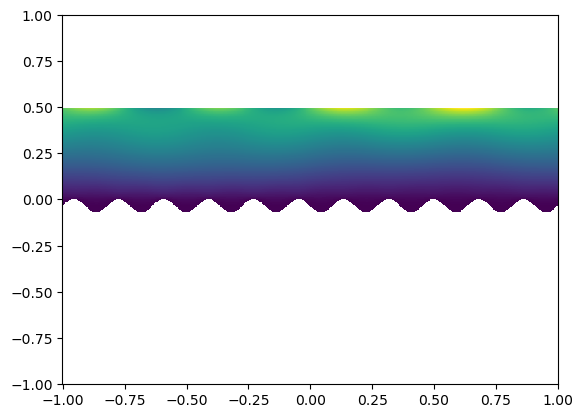

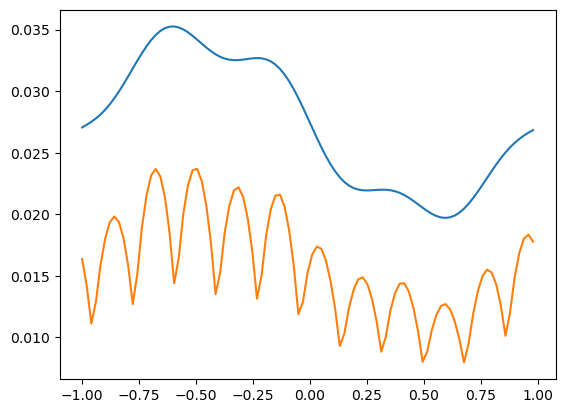

In [ ]:
from scipy.interpolate import RegularGridInterpolator
X = info["X"]
Y = info["Y"]
U = info["Uc"]


#print(X.shape, Y.shape, U.shape)
#help(interp2d)
basis = ScaleShiftedBasisProduct.fromFunctionInDomain(lambda x, y: u, [[-1, 1], [0, 0.5]], 21, 21, FourBasis, ChebBasis)
U_interp = PiecewiseInterp2D(X[0], Y[:, 0], U)


#plt.pcolormesh(X, Y, 0*X)
plt.pcolormesh(X, Y, U_interp(X.flatten(), Y.flatten()).reshape(X.shape))  


plt.figure()
x, y = np.linspace(-1, 1, 100)[:-1], np.zeros(100-1) + 0.005
#plt.plot(np.linspace(0,1,512), U[256, :])
#print(U[300,:])
plt.plot(x, basis(x, y))
plt.plot(x, U_interp(x, y))


KeyboardInterrupt: 

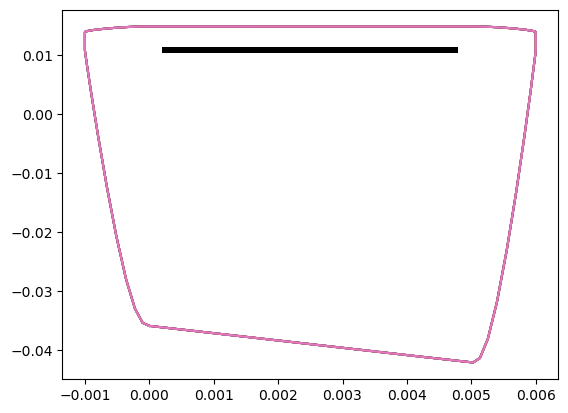

In [ ]:
vecs = []
step = [1, 2, 4, 8, 16, 32, 64, 128]
M_list = [s * 16 for s in step]
for m in M_list:
    problem = StokesTrapezMicProb(data, 0.0, params.width, params.height, 0.0, 8, params.xDim, params.yDim, num_pts=m)
    solver = MicroSolver(problem, tol=1e-10)
    vecs.append(solver.avg_vec)
    problem.plot(plt.gca())
    

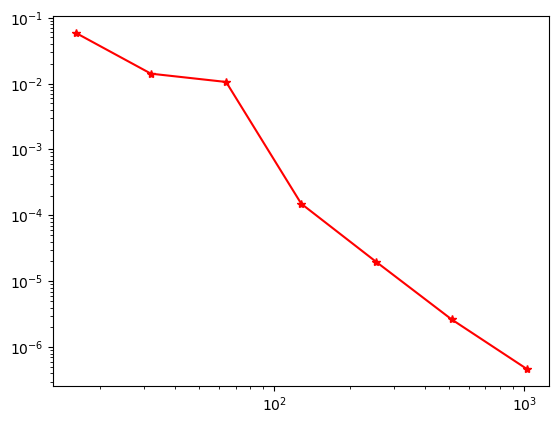

In [ ]:
vec_downsamp = [r[::s] for r,s in zip(vecs, step)]
error = [np.linalg.norm(v - vec_downsamp[-1])/np.linalg.norm(vecs[-1]) for v in vec_downsamp[:-1]]

plt.loglog(M_list[:-1], error, 'r*-')

In [ ]:
# range of data to use : 25 - 59
    
w_list = [3]
n_list = [13]
num_pts = [m]
i_list = list(range(50, 60, 1))

args = [(i, n, w) for i, n, w in product(i_list, n_list, w_list)]

def solve_save(i, n, w):
    data, info = StokesData.load_from_matlab(f"{run_dir}run_{i}.mat")
    data_big_domain = data
    dom = data.dom
    eps = info["eps"]
    print(f"i={i}, (n={n}, w={w}")
    params = HyperParams(nMic=n, xDim=21, yDim=21, width=w*eps, height=w*eps*0.8, tol=1e-8, max_iter=30, num_pts=m)
    setup = Setup(data, params)
    micro_sols, macro_sol, macro_guess = setup.solve()
    setup.save_sol(macro_sol, f"{save_dir}/sol_{i}_{n}_{w}.npy")

In [ ]:

Pool(8).starmap(solve_save, args)

i=50, (n=13, w=3
i=52, (n=13, w=3i=54, (n=13, w=3i=53, (n=13, w=3i=55, (n=13, w=3i=56, (n=13, w=3i=57, (n=13, w=3





i=51, (n=13, w=3
